In [1]:
from mlp import MLP
from train_test import train_model, test_model
import torch
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
import time

In [2]:
print(torch.version)
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.get_arch_list())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

<module 'torch.version' from 'C:\\Users\\Maxwell\\AppData\\Roaming\\Python\\Python310\\site-packages\\torch\\version.py'>
2.0.0+cu118
11.8
['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'compute_37']
1
0


In [3]:
data_path = '../data/release/native/' # '../data/release/template/' for template space prediction
task = 'sex' # 'birth_age' for birth age prediction
#sex for sex prediction
#scan_age for scan age prediction

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 32
epochs = 2000
patience = 200 # for early stopping
lr = 0.001


cuda


In [4]:
#check if datapath is right
file_list = os.listdir(data_path)
print('File num: ', len(file_list))

File num:  1218


In [5]:
train_ids = np.loadtxt('indices/' + task + '_train.txt', dtype='str')
val_ids = np.loadtxt('indices/' + task + '_validation.txt', dtype='str')
test_ids = np.loadtxt('indices/' + task + '_test.txt', dtype='str')

#reshuffle versions
train_ids = np.loadtxt('indices/' + task + '_train_reshuffle.txt', dtype='str')
val_ids = np.loadtxt('indices/' + task + '_val_reshuffle.txt', dtype='str')
test_ids = np.loadtxt('indices/' + task + '_test_reshuffle.txt', dtype='str')

mirror_index = np.load('mirror_index.npy') # mirrors right hemispheres to match with left hemispheres

df = pd.read_csv("combined.csv")

df.insert(0, "ID", "sub-" + df["participant_id"] + "_" + "ses-" + df["session_id"].apply(str))
df.drop("participant_id", axis=1, inplace=True)
df.drop("session_id", axis=1, inplace=True)

df

,ID,birth_age,scan_age,sex,birth_weight,head_circumference_scan
0,sub-CC00050XX01_ses-7201,43.000000,43.29,female,3.910,37.0
1,sub-CC00051XX02_ses-7702,39.857143,40.00,female,3.310,35.0
2,sub-CC00052XX03_ses-8300,38.000000,38.71,female,2.640,33.0
3,sub-CC00053XX04_ses-8607,40.000000,40.43,female,3.460,32.0
4,sub-CC00054XX05_ses-8800,41.857143,42.14,male,3.690,35.0
...,...,...,...,...,...,...
882,sub-CC01232BN12_ses-152130,35.000000,35.43,female,2.140,30.1
883,sub-CC01234AN14_ses-155030,32.857143,33.29,female,2.280,30.5
884,sub-CC01234BN14_ses-155230,32.857143,33.43,female,2.150,31.0
885,sub-CC01236XX16_ses-155830,40.714286,44.43,female,3.675,36.5


In [6]:
def get_data(data_path, task, ids):
    xs = []
    ys = []
    for _id in ids:
        try:
            img_L = nib.load(data_path + _id + '_left.shape.gii')
            x_L = np.stack(img_L.agg_data(), axis=1)
            for i in range(4):
                # replaces the zeros of the medial wall cut area with mean values
                x_L[:, i][x_L[:, i] == 0] = np.mean(x_L[:, i][x_L[:, i] != 0])
            if task == 'birth_age' or task == 'scan_age' or task == 'sex':
                xs.append(x_L.astype(np.float32))
            y = np.array([df.loc[df['ID'] == _id, task].item()])
            if task == 'birth_age' or task == 'scan_age':
                ys.append(y.astype(np.float32))
            elif task == 'sex':
                #print('y[0]: ', y[0])
                sex_indicator = np.zeros(1)
                if y[0] == 'male':
                    sex_indicator += 1
                #print("this works")
                ys.append(sex_indicator.astype(np.float32))    
                #print("this doesn't")            
            
            img_R = nib.load(data_path + _id + '_right.shape.gii')
            x_R = np.stack(img_R.agg_data(), axis=1)[mirror_index] # mirroring
            for i in range(4):
                # replaces the zeros of the medial wall cut area with mean values
                x_R[:, i][x_R[:, i] == 0] = np.mean(x_R[:, i][x_R[:, i] != 0])
            if task == 'birth_age' or task == 'scan_age' or task == 'sex':
                xs.append(x_R.astype(np.float32))

            y = np.array([df.loc[df['ID'] == _id, task].item()])
            if task == 'birth_age' or task == 'scan_age':
                ys.append(y.astype(np.float32))
            elif task == 'sex':
                #print('y[0]: ', y[0])
                sex_indicator = np.zeros(1)
                if y[0] == 'male':
                    sex_indicator += 1
                ys.append(sex_indicator.astype(np.float32))  
        except:
            print('train set element %s does not exist' % _id)
    return xs, ys

train_xs, train_ys = get_data(data_path, task, train_ids)
val_xs, val_ys = get_data(data_path, task, val_ids)
test_xs, test_ys = get_data(data_path, task, test_ids)


train set element sub-CC00371XX09_ses-134700 does not exist
train set element sub-CC00319XX14_ses-117300 does not exist
train set element sub-CC00307XX10_ses-98800 does not exist
train set element sub-CC00061XX04_ses-13300 does not exist
train set element sub-CC00217XX11_ses-73700 does not exist
train set element sub-CC00291XX12_ses-93100 does not exist
train set element sub-CC00084XX11_ses-31201 does not exist
train set element sub-CC00501XX06_ses-146500 does not exist
train set element sub-CC00221XX07_ses-75000 does not exist
train set element sub-CC00468XX15_ses-139100 does not exist
train set element sub-CC00341XX12_ses-108000 does not exist
train set element sub-CC00439XX19_ses-132100 does not exist
train set element sub-CC00227XX13_ses-92100 does not exist
train set element sub-CC00143AN12_ses-47501 does not exist
train set element sub-CC00170XX06_ses-56100 does not exist
train set element sub-CC00442XX14_ses-133300 does not exist


In [7]:
length_list_train_xs = [len(inner_list) for inner_list in train_xs]
mode = max(set(length_list_train_xs), key=length_list_train_xs.count)
offsize_list_ind = [i for i in range(len(length_list_train_xs)) if length_list_train_xs[i] != mode]
only_correct_sized_train_xs = [train_xs[i] for i in range(len(length_list_train_xs)) if length_list_train_xs[i] == mode]
train_xs = np.transpose(only_correct_sized_train_xs, axes=[1, 2, 0])

length_list_val_xs = [len(inner_list) for inner_list in val_xs]
mode = max(set(length_list_val_xs), key=length_list_val_xs.count)
offsize_list_ind = [i for i in range(len(length_list_val_xs)) if length_list_val_xs[i] != mode]
only_correct_sized_val_xs = [val_xs[i] for i in range(len(length_list_val_xs)) if length_list_val_xs[i] == mode]
val_xs = np.transpose(only_correct_sized_val_xs, axes=[1, 2, 0])

length_list_test_xs = [len(inner_list) for inner_list in test_xs]
mode = max(set(length_list_test_xs), key=length_list_test_xs.count)
offsize_list_ind = [i for i in range(len(length_list_test_xs)) if length_list_test_xs[i] != mode]
only_correct_sized_test_xs = [test_xs[i] for i in range(len(length_list_test_xs)) if length_list_test_xs[i] == mode]
test_xs = np.transpose(only_correct_sized_test_xs, axes=[1, 2, 0])



In [8]:
# data standardization

#train_xs = np.transpose(np.array(train_xs, dtype=object), axes=[1, 2, 0])
means  = np.mean(np.mean(train_xs, axis=2), axis=0) # means of the 4 channels in the train set
stds  = np.std(np.std(train_xs, axis=2), axis=0) # stds of the 4 channels in the train set
train_xs = (train_xs - means.reshape(1, means.shape[0], 1)) / stds.reshape(1, means.shape[0], 1)
train_xs = np.transpose(train_xs, axes=[2, 0, 1])

#val_xs = np.transpose(val_xs, axes=[1, 2, 0])
val_xs = (val_xs - means.reshape(1, means.shape[0], 1)) / stds.reshape(1, means.shape[0], 1)
val_xs = np.transpose(val_xs, axes=[2, 0, 1])

#test_xs = np.transpose(test_xs, axes=[1, 2, 0])
test_xs = (test_xs - means.reshape(1, means.shape[0], 1)) / stds.reshape(1, means.shape[0], 1)
test_xs = np.transpose(test_xs, axes=[2, 0, 1])

In [9]:
train_subset = [(torch.from_numpy(x), torch.from_numpy(y)) for x, y in zip(train_xs, train_ys)]

val_subset = [(torch.from_numpy(x), torch.from_numpy(y)) for x, y in zip(val_xs, val_ys)]

test_subset = [(torch.from_numpy(x), torch.from_numpy(y)) for x, y in zip(test_xs, test_ys)]


In [10]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=len(val_subset), shuffle=False)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=len(test_subset), shuffle=False)

model = MLP(4, [16, 16, 16, 16], 1, device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(model)
print('Number of parameters: ', sum(p.numel() for p in model.parameters() if p.requires_grad))


MLP(
  (lin1): Linear(in_features=4, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin2): Linear(in_features=16, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin3): Linear(in_features=16, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin4): Linear(in_features=16, out_features=16, bias=True)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin5): Linear(in_features=16, out_features=16, bias=True)
  (lin6): Linear(in_features=16, out_features=1, bias=True)
)
Number of parameters:  1313


In [11]:
train_losses = []
val_losses = []
test_losses = []

best_val_index = -1

training_start_time = time.time()
time_array = []
time_array.append(training_start_time)



for epoch in range(epochs):
    train_loss = train_model(train_loader, model, optimizer).cpu().detach().numpy()
    val_loss = test_model(val_loader, model).cpu().detach().numpy()
    test_loss = test_model(test_loader, model).cpu().detach().numpy()
    new_min = " "
    if epoch > 0:
        if val_losses[best_val_index] > val_loss:
            new_min = "*"
            best_val_index = epoch
            torch.save(model.state_dict(), 'MLP_sex_impatient_reshuffle_05.pt') #this thankfully already saves the best val loss model
        #temporarily disable early stoppage
        # early stopping is called
        if len(val_losses) - best_val_index > patience:
            print ("Early stopping, best val loss and index:")
            print(val_losses[best_val_index], best_val_index)
            break
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    print(new_min, "Epoch: %d, train loss: %1.3f, val loss: %1.3f, test loss: %1.3f" % (epoch, train_loss, val_loss, test_loss))
    time_array.append(time.time())

    


  Epoch: 0, train loss: 0.672, val loss: 0.534, test loss: 0.512
* Epoch: 1, train loss: 0.544, val loss: 0.501, test loss: 0.494
* Epoch: 2, train loss: 0.518, val loss: 0.494, test loss: 0.493
* Epoch: 3, train loss: 0.496, val loss: 0.478, test loss: 0.487
* Epoch: 4, train loss: 0.485, val loss: 0.474, test loss: 0.483
  Epoch: 5, train loss: 0.483, val loss: 0.483, test loss: 0.489
  Epoch: 6, train loss: 0.483, val loss: 0.487, test loss: 0.494
* Epoch: 7, train loss: 0.485, val loss: 0.473, test loss: 0.482
  Epoch: 8, train loss: 0.485, val loss: 0.476, test loss: 0.485
  Epoch: 9, train loss: 0.486, val loss: 0.475, test loss: 0.485
  Epoch: 10, train loss: 0.485, val loss: 0.493, test loss: 0.498
  Epoch: 11, train loss: 0.480, val loss: 0.494, test loss: 0.501
  Epoch: 12, train loss: 0.485, val loss: 0.488, test loss: 0.494
  Epoch: 13, train loss: 0.484, val loss: 0.484, test loss: 0.492
  Epoch: 14, train loss: 0.487, val loss: 0.480, test loss: 0.488
  Epoch: 15, train l

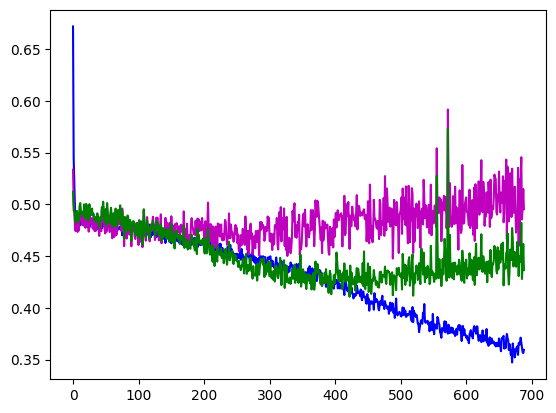

In [12]:
plt.plot(train_losses, color='b')
plt.plot(val_losses, color='m')
plt.plot(test_losses, color='g')
plt.show()

In [13]:
#Retrieve best val loss
best_val_loss = val_losses[best_val_index]


In [14]:
#timing recordings

end_time = time.time()
total_train_time = end_time - training_start_time
time_differences = []
for i in range(len(time_array) - 1):
    last_time = time_array[i]
    this_time = time_array[i + 1]
    diff = this_time - last_time
    time_differences.append(diff)
    

average_time = total_train_time / len(time_array)

print("Total time: ", round(total_train_time / 60, 2), " mins")
print("Average training time: ", round(average_time, 2), " seconds")
print("Longest training time: ", round(max(time_differences), 2), "seconds")
print("Shortest training time: ", round(min(time_differences), 2), "seconds")
print("\nBest Val Loss: ", best_val_loss, " at epoch num ", best_val_index)

Total time:  10.87  mins
Average training time:  0.95  seconds
Longest training time:  4.86 seconds
Shortest training time:  0.91 seconds

Best Val Loss:  0.4475972  at epoch num  488


In [15]:
from train_test import display_test_stats

In [16]:
# Check against a saved version of the model
model_choice = 'MLP_sex_impatient_reshuffle_05.pt'
model = MLP(4, [16, 16, 16, 16], 1, device=device)
model.load_state_dict(torch.load(model_choice))
model.eval()


MLP(
  (lin1): Linear(in_features=4, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin2): Linear(in_features=16, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin3): Linear(in_features=16, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin4): Linear(in_features=16, out_features=16, bias=True)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin5): Linear(in_features=16, out_features=16, bias=True)
  (lin6): Linear(in_features=16, out_features=1, bias=True)
)

In [17]:
test_loss, predictions, truths, mae = display_test_stats(val_loader, model)
#mae is same as test_loss, but calculated differently and unneeded.
print("Best loss from saved model: ", test_loss)
if task == 'sex':
    print("0 is female, 1 is male")
print("Predictions: ", predictions, '\n')


This ran
Best loss from saved model:  tensor(0.4476, device='cuda:0')
0 is female, 1 is male
Predictions:  [tensor([[ 1.0924],
        [ 0.8085],
        [ 0.4835],
        [ 0.2418],
        [ 1.0076],
        [ 0.9869],
        [ 0.7353],
        [ 0.8627],
        [ 0.4049],
        [ 0.4877],
        [ 0.4681],
        [ 0.4530],
        [ 0.3240],
        [ 0.5526],
        [ 0.4042],
        [ 0.1616],
        [ 0.6230],
        [ 0.5646],
        [ 0.1103],
        [ 0.4536],
        [ 0.6156],
        [ 0.8114],
        [ 0.5661],
        [ 0.6531],
        [ 0.5952],
        [ 0.4771],
        [ 0.7198],
        [ 0.4951],
        [ 0.5671],
        [ 0.3376],
        [ 0.6733],
        [ 0.4165],
        [ 0.5686],
        [ 0.7747],
        [ 0.2303],
        [ 0.4422],
        [ 0.1168],
        [ 0.1720],
        [ 0.4843],
        [ 0.6656],
        [ 0.3702],
        [ 0.6155],
        [ 0.7383],
        [ 0.7621],
        [ 0.4662],
        [ 0.6177],
        [ 0.5803],